**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [4]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [6]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [7]:
df_raw['YearMade'].value_counts()

1000    38185
1998    21221
2005    20587
2004    20020
1997    18905
1999    18767
2000    16742
1996    16691
1995    15528
1994    14199
2003    14161
2001    12938
2006    12215
2002    12031
1993    10971
1989    10693
1988    10395
1990    10250
1987    10105
1992     7587
1986     7508
1991     7361
1985     6475
1984     6111
1978     5623
1979     5557
1980     4677
1983     4557
2007     4523
1977     4379
        ...  
1967     1086
1966      943
1965      667
1964      414
1963      246
2009      168
1962      143
1919      127
1961       99
1960       97
1959       28
2010       25
1958       22
1956       20
2011       18
1920       17
1957       15
1950        8
1951        7
1953        6
1952        6
1955        5
1954        3
1948        3
2012        1
1949        1
1947        1
1942        1
1937        1
2013        1
Name: YearMade, Length: 72, dtype: int64

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [11]:
set_rf_samples(50000)

In [10]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20595627732286173, 0.2490314232568958, 0.9113487440591961, 0.8892468020100115, 0.8942464824985739]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [30]:
df_raw = pd.read_feather('tmp/bulldozers-raw')
df_raw = df_raw[df_raw['YearMade']!=1000]
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [8]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [32]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1914997239415497, 0.23739013905580725, 0.9226042579354663, 0.9010208467109945, 0.9061313692133017]


In [33]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.58 s, sys: 170 µs, total: 1.58 s
Wall time: 1.58 s


(10.495078766239576, 0.407184603383973)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [9]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

NameError: name 'm' is not defined

NameError: name 'preds' is not defined

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

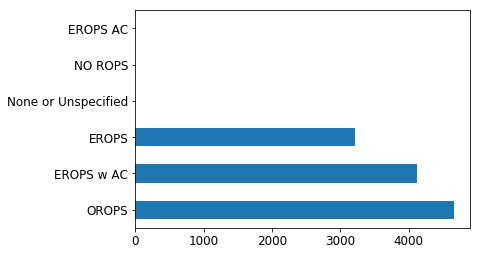

In [35]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [36]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.875022,9.864482,0.265351
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.656867,10.614261,0.262666
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.703035,9.704566,0.213733


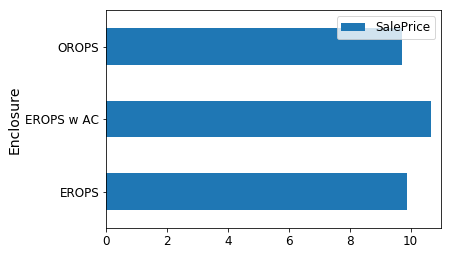

In [37]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

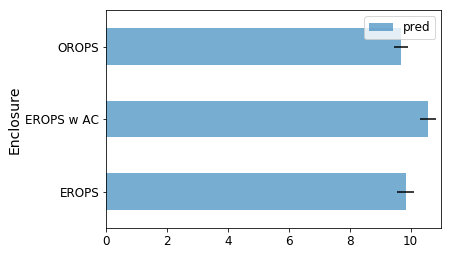

In [ ]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

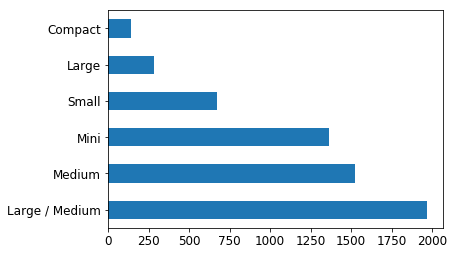

In [38]:
raw_valid.ProductSize.value_counts().plot.barh();

In [39]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.750177,9.839319,0.319216
Large,10.526426,10.439839,0.334371
Large / Medium,10.729944,10.679692,0.295310
Medium,10.718177,10.668829,0.274972
Mini,9.547050,9.572639,0.243722
Small,10.403902,10.393703,0.290989


????

The lower the std the better -> Less variation in the prediction

In [40]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.032443
Large             0.032028
Small             0.027997
Large / Medium    0.027652
Medium            0.025773
Mini              0.025460
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [41]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.180593
13,ProductSize,0.115513
37,Coupler_System,0.084095
14,fiProductClassDesc,0.074203
39,Hydraulics_Flow,0.066595
63,saleElapsed,0.051070
38,Grouser_Tracks,0.043808
10,fiSecondaryDesc,0.043385
19,Enclosure,0.037630
2,ModelID,0.037069


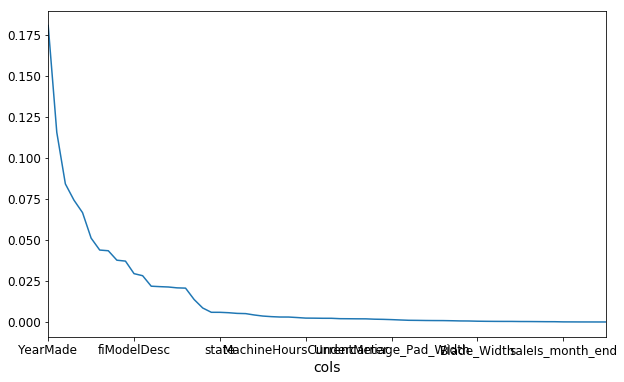

In [42]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [18]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

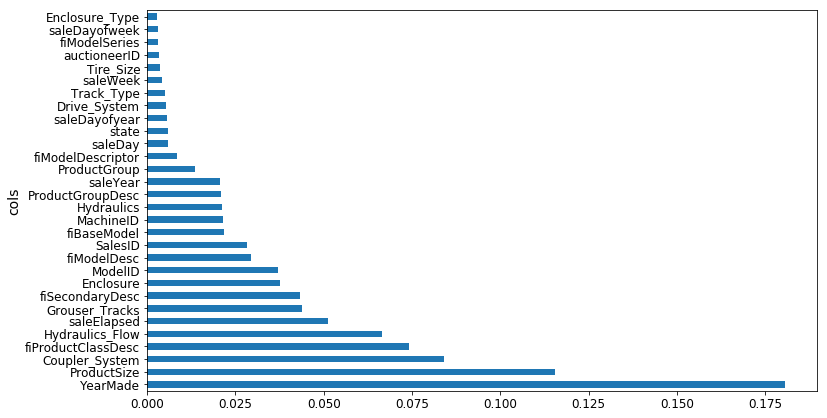

In [44]:
plot_fi(fi[:30]);

In [45]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [46]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1926646633675666, 0.23738778646644523, 0.9216597595706981, 0.9010228085123583, 0.9057912216073236]


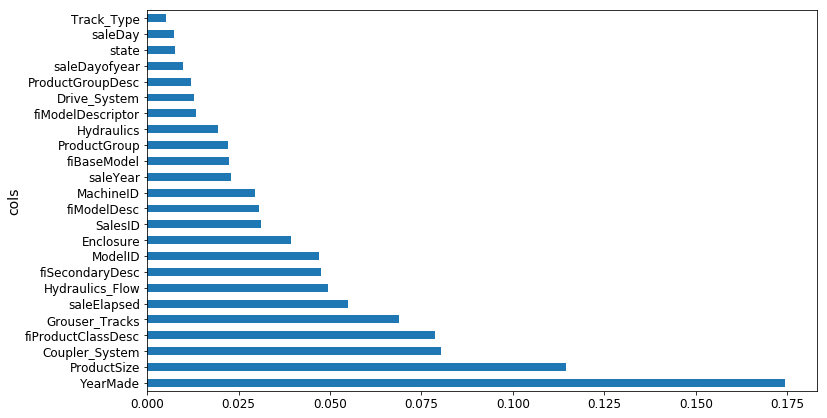

In [48]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [49]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.19217963412075934, 0.24216396308615193, 0.9220537028962078, 0.8969999547754831, 0.9049988562601028]


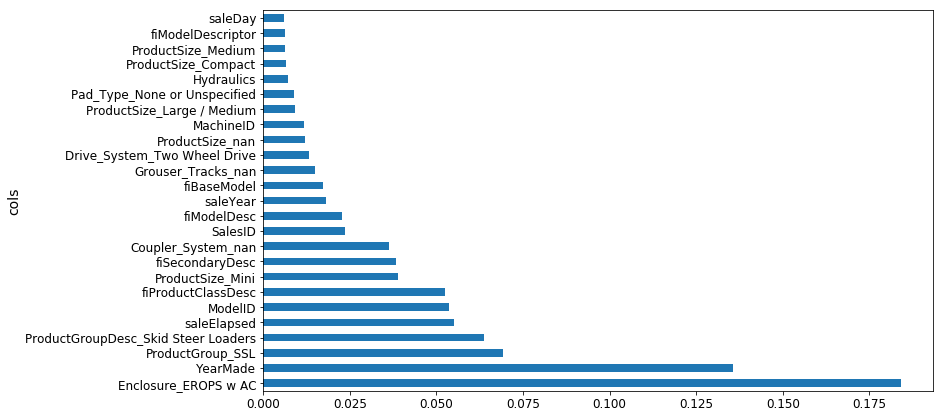

In [50]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [10]:
from scipy.cluster import hierarchy as hc

sale year and sale elapsed v similiar

the closer to the right the more similiar

correlation coefficient almost the same as r2 but between two variables rather than a variable and a prediction

Rank correlation plot the rank instead of data

What is the rank of a variable?

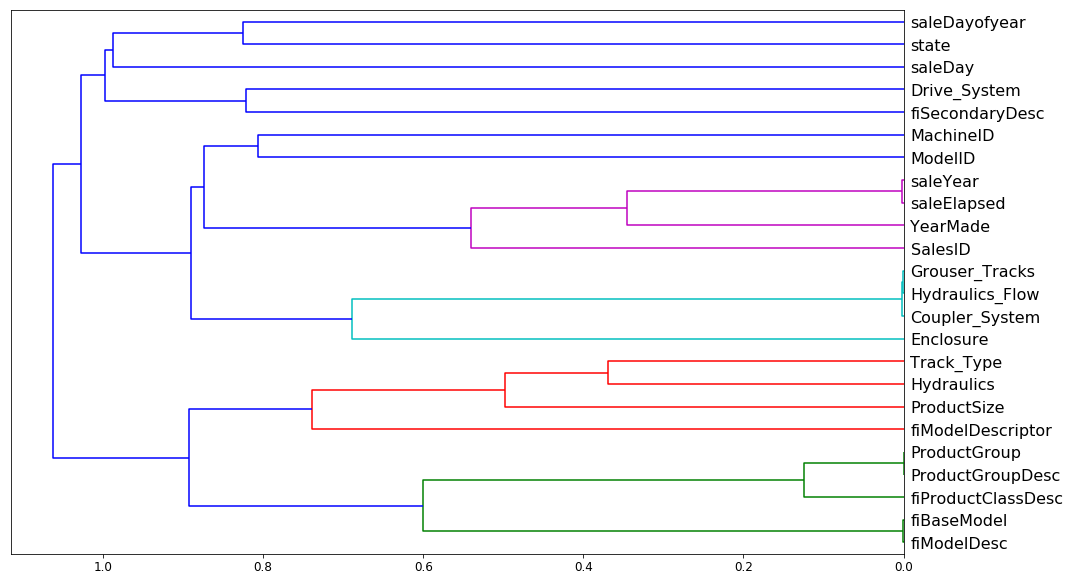

In [53]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [14]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [15]:
get_oob(df_keep)

0.8880211378470435

Now we try removing each variable one at a time.

Check effect on oob score of removing each of these columns

removed one at a time

In [56]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.9005758073855904
saleElapsed 0.8995841389925351
fiModelDesc 0.900801894695323
fiBaseModel 0.9018329961522724
Grouser_Tracks 0.9021288135873416
Coupler_System 0.9014176194508174


It looks like we can try one from each group for removal. Let's see what that does.

Why remove grouser tracks and not coupler system even though grouser tracks results in an increase in r2

In [62]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.9014159439910353

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [63]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [64]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [11]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [12]:
reset_rf_samples()

In [13]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11911081890378454, 0.22888982158477283, 0.970349143221564, 0.9064376901103777, 0.9117387251323472]


# Partial dependence

How do the important features relate to the independent variable

In [24]:
from pdpbox import pdp
from plotnine import *

In [15]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [16]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

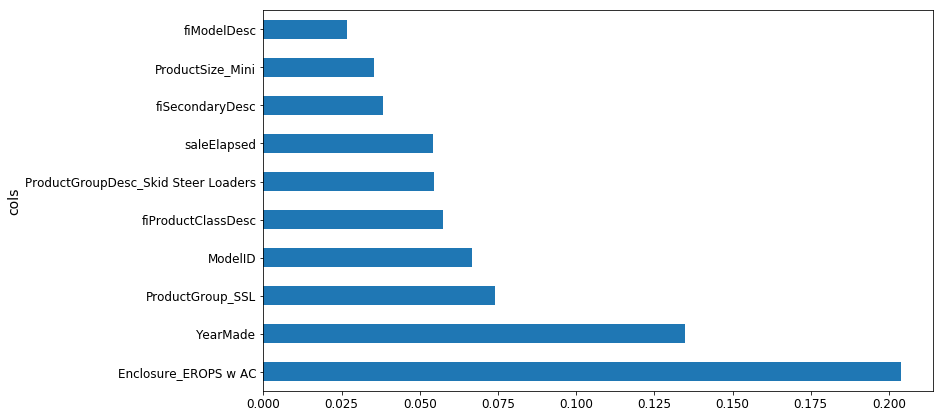

In [19]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

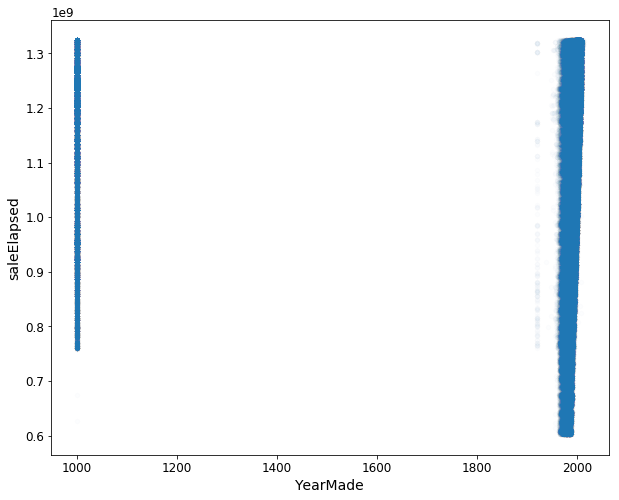

In [20]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [21]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

In [26]:
! pip install skmisc

  Could not find a version that satisfies the requirement skmisc (from versions: )
No matching distribution found for skmisc


In [27]:
?? ggplot

In [25]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

PlotnineError: "For loess smoothing, install 'scikit-misc'"

In [28]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [29]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

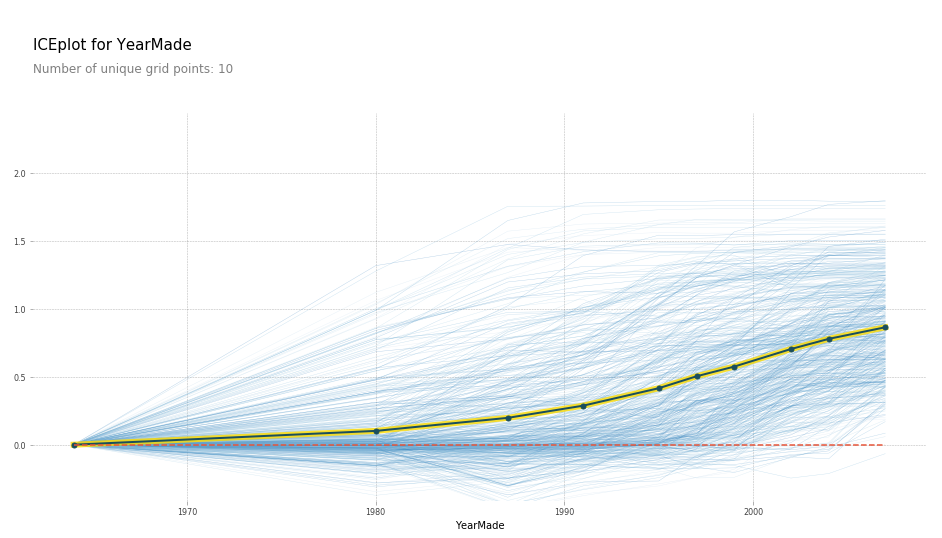

In [30]:
plot_pdp('YearMade')

Replace year for all with 1960, 1961 etc etc

What would all the examples have sold for if they were made in 1960, 1961 etc?? 

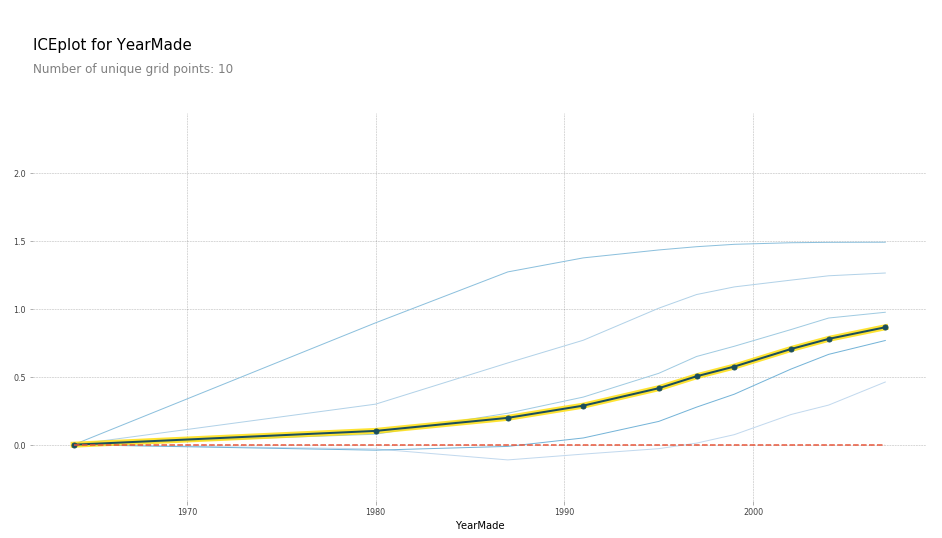

In [31]:
plot_pdp('YearMade', clusters=5)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

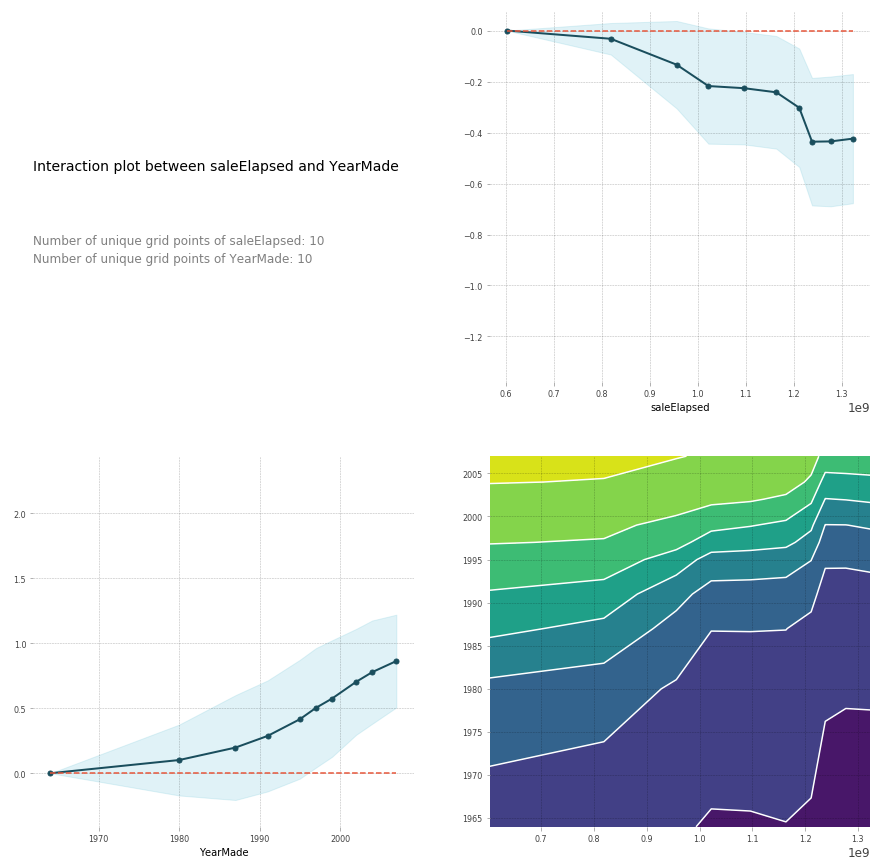

In [32]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

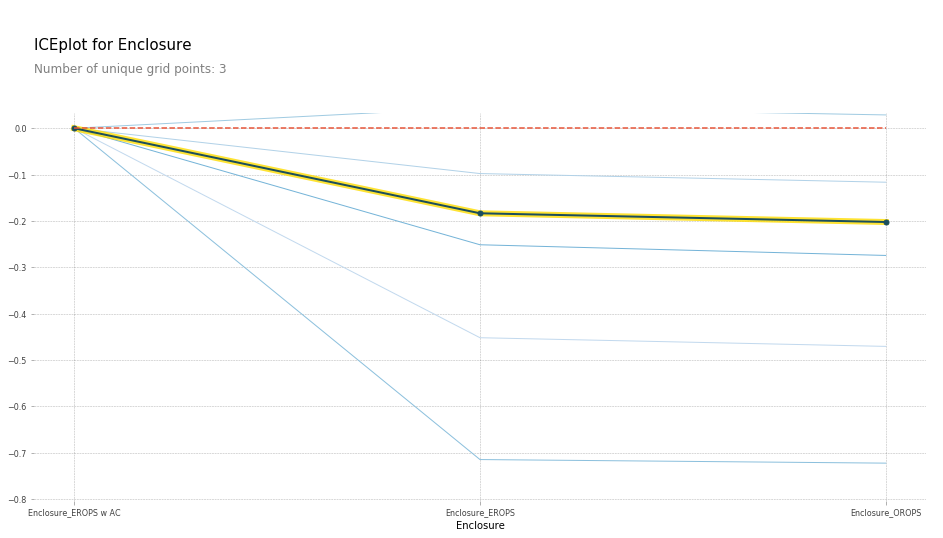

In [33]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [34]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

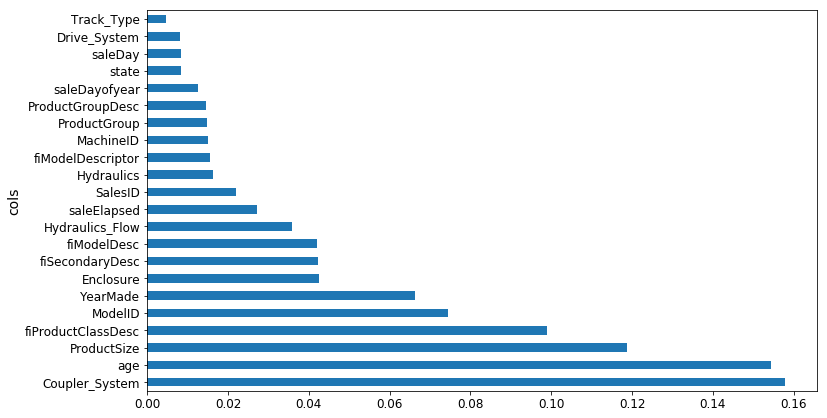

In [35]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [36]:
from treeinterpreter import treeinterpreter as ti

In [37]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [38]:
row = X_valid.values[None,0]; row

array([[      1999,          5,          0,         17,          0, 1284595200,          0,          1,
               665,       3232,    4364751,    2300944,         12,          4,          4,          0,
                16,         35,        259,          0,          2,         11]])

In [39]:
prediction, bias, contributions = ti.predict(m, row)

bias - average sale price across whole original data set

In [40]:
prediction[0], bias[0]

(array([9.30256]), 10.105237295126916)

In [41]:
idxs = np.argsort(contributions[0])

How much the predicted sale price was increased or decreased by each variable

In [42]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.546430141222672),
 ('age', 11, -0.10942803788646174),
 ('fiModelDesc', 'KX1212', -0.10937623681781314),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.09980723221347584),
 ('fiSecondaryDesc', nan, -0.07263276550349143),
 ('saleElapsed', 1284595200, -0.042461549770783244),
 ('fiModelDescriptor', nan, -0.023807984263239844),
 ('saleDayofyear', 259, -0.020174364035582926),
 ('ProductGroup', 'TEX', -0.013642274044218583),
 ('saleDay', 16, -0.004814602021026282),
 ('Hydraulics', 'Standard', -0.003962557204005623),
 ('Enclosure', 'EROPS', -0.0021771035836595674),
 ('Drive_System', nan, -0.0017444853017563934),
 ('SalesID', 4364751, -0.0016461293123197329),
 ('MachineID', 2300944, -0.0009039093206408833),
 ('state', 'Ohio', 0.0011104430289401001),
 ('Hydraulics_Flow', nan, 0.013226924398038298),
 ('ProductGroupDesc', 'Track Excavators', 0.014303909683318938),
 ('Track_Type', 'Steel', 0.022963654216603846),
 ('ModelID', 665, 0.

In [43]:
contributions[0].sum()

-0.8026808480126539

# Extrapolation

In [ ]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.99998753505765037

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.764744
5,saleElapsed,0.146162
11,MachineID,0.077919
8,fiModelDesc,0.002931
20,saleDayofyear,0.002569
0,YearMade,0.002358
22,age,0.001202
4,ModelID,0.000664
6,fiSecondaryDesc,0.000361
1,Coupler_System,0.000208


In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [ ]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [ ]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [ ]:
x.drop(feats, axis=1, inplace=True)

In [ ]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9789018385789966

In [ ]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.233626
0,YearMade,0.188127
17,saleDayofyear,0.157429
4,ModelID,0.077623
7,fiModelDesc,0.061301
15,saleDay,0.056252
14,state,0.055201
3,fiProductClassDesc,0.035131
5,fiSecondaryDesc,0.023661
6,Enclosure,0.022409


In [ ]:
set_rf_samples(50000)

In [ ]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [ ]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.21136509778791376, 0.2493668921196425, 0.90909393040946562, 0.88894821098056087, 0.89255408392415925]


In [ ]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20918653475938534, 0.2459966629213187, 0.9053273181678706, 0.89192968797265737, 0.89245205174299469]
saleElapsed
[0.2194124612957369, 0.2546442621643524, 0.90358104739129086, 0.8841980790762114, 0.88681881032219145]
MachineID
[0.206612984511148, 0.24446409479358033, 0.90312476862123559, 0.89327205732490311, 0.89501553584754967]
age
[0.21317740718919814, 0.2471719147150774, 0.90260198977488226, 0.89089460707372525, 0.89185129799503315]
YearMade
[0.21305398932040326, 0.2534570148977216, 0.90555219348567462, 0.88527538596974953, 0.89158854973045432]
saleDayofyear
[0.21320711524847227, 0.24629839782893828, 0.90881970943169987, 0.89166441133215968, 0.89272793857941679]


In [ ]:
reset_rf_samples()

In [ ]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1418970082803121, 0.21779153679471935, 0.96040441863389681, 0.91529091848161925, 0.90918594039522138]


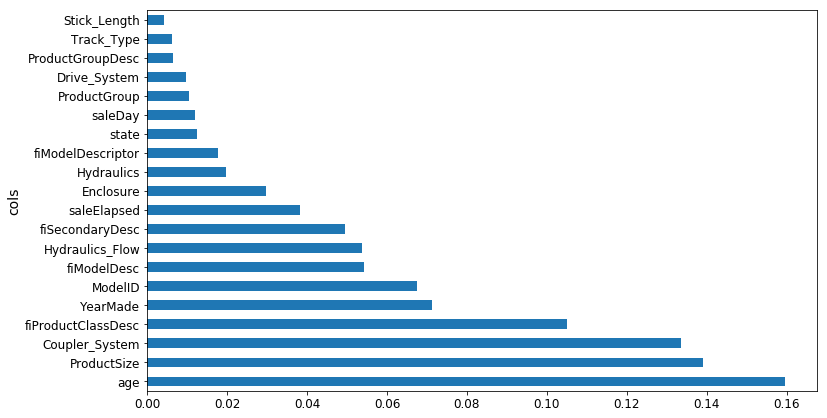

In [ ]:
plot_fi(rf_feat_importance(m, X_train));

In [ ]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 6min 3s, sys: 2.75 s, total: 6min 6s
Wall time: 16.7 s
[0.08104912951128229, 0.2109679613161783, 0.9865755186304942, 0.92051576728916762, 0.9143700001430598]
